Shallow Focusing
=
> ## 목차
> ---
> ### 1. 실행 방법   
> ### 2. 목표 및 의의   
> ### 3. 이론 [go](#3-이론)
>   > 1 Semantic Segmentation    
>   > 2 Instance Segmentation   

> ### 4. 코드 분석 [go](#4-코드-분석)
>   > [0 코드 흐름](#0-코드-흐름)   
>   > [1 데이터 준비](#1-데이터-준비-및-전처리)    
>   > [2 모델 설계 및 실험](#2-모델-설계-및-실험)   
>   > [3 모델 평가](#3-모델-평가)   
> ### 5. 아쉬운 점 [go](#5-아쉬운-점)

<br><br><br>

- - - -

## 1. 실행 방법
 1. repository를 내려받는다. ``` git clone https://github.com/SunCreation/aiffel.git ```   
 2. 원하는 사진을 ```aiffel/Working/AI/human_segmentation/images``` 에 위치시킨다.   
 3. ```aiffel/Working/AI/human_segmentation/``` 에서 shallow_focus.py를 실행한다.: ``` python3 shallow_focus.py ```
 4. Working폴더의 위치를 입력한다.  
 5. 다음은 원하는 대로 진행한다.

<br><br><br>

- - - -

## 2. 목표 및 의의

### 1) 완성된 모델을 이용하여, Semantic Segmentation을 구현해본다. 인물과 배경을 분리하여, 인물모드 사진을 만들어보고, 배경 합성들을 해본다.     

### 2) Semantic Segmentation의 한계점을 분석해보고 해결방안을 생각해본다.
<br><br><br><br>

- - - - 
## 3. 이론

<br><br><br><br>

- - - -
## 4. 코드 분석

먼저 다른 모델을 가져와서 그것으로 semantic sagmentation을 진행할 예정입니다.   
모델은 구글에서 개발한 DeepLab V3+을 사용하겠습니다. 

먼저 모델을 만드는데 사용할 클래스를 정의하겠습니다.

In [1]:

import warnings
warnings.filterwarnings("ignore")
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import cv2
import numpy as np
import os
import tarfile
import urllib
import re

from matplotlib import pyplot as plt
import tensorflow as tf

import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('frot', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    pass # print('Unknown system... sorry~~~~',platform.system())
# [f.fname for f in font_manager.fontManager.ttflist if 'Nanum' in f.name]

plt.rcParams["font.family"] = 'NanumSquare'

어떤 사진을 shallow focus할까요?

1번: 인물사진.JPG
2번: his_dog.jpg
3번: her_dogs.jpg
4번: dog.jpg
5번: 겹친사람.JPG
6번: cat_inthe_guitarcase.JPG


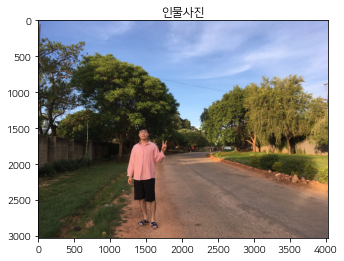

(3024, 4032, 3)


In [2]:
Workingpath = input("\n\n\n\n\n사용자의 home 디렉토리에서 Working파일 사이의 경로를 입력하세요.\
    \n(ex: /aiffel/assignment   ,  Working파일이 Home 디렉토리에 있다면, 그냥 Enter를 누르세요.) :")
image_path = os.getenv('HOME')+Workingpath+'/Working/AI/human_segmentation/images/'
image_list = os.listdir(image_path)

def select_img(image_list):
    n=0
    while n==0 :
        print("어떤 사진을 shallow focus할까요?\n")
        num=1

        for i in image_list:
            print(str(num)+'번:', i)
            num += 1    

        try:
            a = input("사진에 해당하는 번호를 입력하세요:")
            b = int(a[:re.search('[0-9]+',a).end()])

        except:
            print('\n\n\n\n숫자를 골라주세요!\n\n\n\n\n')
            continue
        n=1

    return b

n=0
while n==0:
    num = select_img(image_list)
    image_name = image_list[num-1]
    img_orig = cv2.imread(image_path + image_name)
    img_show = img_orig.copy()
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)    
    plt.imshow(img_rgb)
    only_imagename = os.path.splitext(image_name)[0]
    plt.title(only_imagename)
    plt.show()
    end=input("이 사진으로 하시겠어요? (y/n)\n\n:")
    if end == 'y' or end == 'yes' or end == 'Y':
        n=1


# img_path = os.getenv('HOME')+Workingpath+'/Working/AI/human_segmentation/images/인물사진.JPG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
# img_orig = cv2.imread(img_path) 
print (img_orig.shape)

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME') + Workingpath + '/Working/AI/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
# 다운로드 완료
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

img_resized, seg_map = MODEL.run(img_orig)
print ('원본 이미지 크기:', img_orig.shape,'수정 후 이미지 크기:', img_resized.shape,'최대 수치:', seg_map.max())

temp directory: /home/hchang/Working/AI/human_segmentation/models
model loaded successfully!
원본 이미지 크기: (3024, 4032, 3) 수정 후 이미지 크기: (384, 513, 3) 최대 수치: 15


In [5]:
import numpy as np
import pandas as pd
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

def labe(list):
    lab = pd.DataFrame()
    lab['label'] = list
    
    print(lab)
    num = int(input('어떤 대상을 출력하시겠어요?(숫자만 입력해주세요):'))
    return num
n=0
while n==0:
    try:
        num = labe(LABEL_NAMES)
        label_name = LABEL_NAMES[num]
        a = input(label_name+'를 선택하시겠어요?(y/n)')
        if a != 'y':
            continue
        n=1
    except:
        print('적절한 숫자가 아닙니다.')

          label
0    background
1     aeroplane
2       bicycle
3          bird
4          boat
5        bottle
6           bus
7           car
8           cat
9         chair
10          cow
11  diningtable
12          dog
13        horse
14    motorbike
15       person
16  pottedplant
17        sheep
18         sofa
19        train
20           tv


Text(0.5, 1.0, 'person segmentation map')

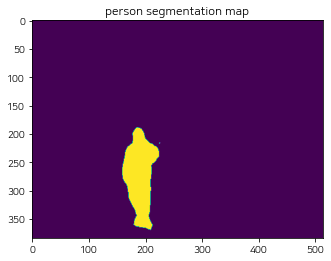

In [6]:
seg_map = np.where(seg_map==num,15,0)

plt.imshow(seg_map)
plt.title(label_name+' segmentation map')

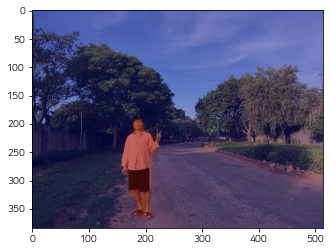

In [7]:
img_show = img_resized.copy()
# seg_map = np.where(seg_map == 12, 15, 0) # 예측 중 사람만 추출, 위에 선택한 것만
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

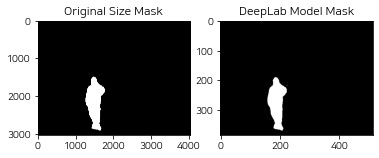

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

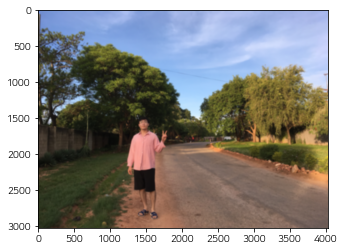

In [9]:
img_orig_blur = cv2.blur(img_orig, (20,20)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

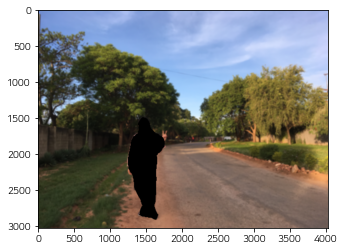

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

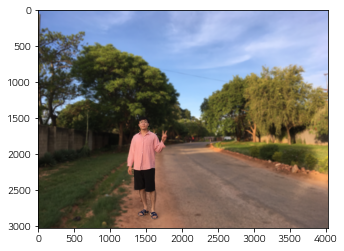

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
cv2.imwrite('output/'+only_imagename+'.png',img_concat)

True